<img src = "https://raw.githubusercontent.com/barcelonagse-datascience/academic_files/master/images/BSE_DSC_HEADER.jpg">

# Project: k-Nearest Neighbors and SVM


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.

Please don't use any feature that you infer you don't know the first day of a patient in an ICU. In particular, please remove from both the training and testing sets 'DOD' 'DISCHTIME', 'DEATHTIME' and 'LOS'

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you should use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build kNN and SVM predictive models for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is a test dataset, *mimic_test_death.csv*. Apply your final model to this test dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset.
2. Manage missing data.
2. Manage categorial features.
3. Build a prediction model.
5. Assess expected accuracy and tune your models using *cross-validation*.
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Data preparation - <b>30%</b>
+ Nearest neighbor method(s) have been used - <b>10%</b>
+ kNN Probability of death for each test patient is computed - <b>5%</b>
+ kNN Accuracy of predictions for test patients is calculated (kaggle) - <b>10%</b>
+ kNN Hyperparameter optimization - <b>10%</b>
+ SVM method(s) have been used - <b>10%</b>
+ SVM Probability of death for each test patient is computed - <b>5%</b>
+ SVM Accuracy of predictions for test patients is calculated (kaggle) - <b>10%</b>
+ SVM Hyperparameter optimization - <b>10%</b>


# k-Nearest Neighbours

In [207]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce
import datetime
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
import warnings
from category_encoders import TargetEncoder
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif
from sklearn.svm import SVC 
warnings.filterwarnings("ignore")


## 1. LOAD DATA

In [139]:
# Training dataset
df_train=pd.read_csv(r'C:\Users\julia\OneDrive\Documentos\DSDM\2nd TERM\Computational Learning\DL_materials\project\dl24-probability-of-death-with-k-nn\mimic_train.csv')

#Extra data
mimic_metadata=pd.read_csv(r'C:\Users\julia\OneDrive\Documentos\DSDM\2nd TERM\Computational Learning\DL_materials\project\dl24-probability-of-death-with-k-nn\MIMIC_metadata_diagnose.csv')
mimic_diagnose=pd.read_csv(r'C:\Users\julia\OneDrive\Documentos\DSDM\2nd TERM\Computational Learning\DL_materials\project\dl24-probability-of-death-with-k-nn\extra_data\MIMIC_diagnoses.csv')

# Test dataset (to produce predictions)
df_test=pd.read_csv(r'C:\Users\julia\OneDrive\Documentos\DSDM\2nd TERM\Computational Learning\DL_materials\project\dl24-probability-of-death-with-k-nn\mimic_test_death.csv')
df_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [140]:
#drop columns in train data that are not in test data
df_train.drop(columns=['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], inplace=True)

## 2. TREAT AND ADD EXTRA DATA 

We observe that mimic_diagnose data has information of different illness that have been detected for each patient in each of their hospitalizations.

We will extract three features from these dataset:
 1)  number of hospitalizations of each patient as logically it may be positively correlated with probability of death.
 2) number of illnesses diagnosed for each hospitalization, for the same reason.
 3) all the codes that have been detected by sequence order in a hospitalization.

Regarding mimic_metadata, we observe it only has descriptions of the codes, so we decide not to use it since it does not any value.

In [31]:
mimic_diagnose.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [141]:
#1)Count the number of different illnesses that the patient had in each hospitalization
mimic_diagnose_n_diagnoses = mimic_diagnose.groupby('HADM_ID')['ICD9_CODE'].nunique()
mimic_diagnose_n_diagnoses = mimic_diagnose_n_diagnoses.reset_index(name='Number Diagnoses')

#2)Count the number of hospitalizations that a patient had up to the last one registered
mimic_diagnose_n_hosp = mimic_diagnose.groupby('SUBJECT_ID')['HADM_ID'].nunique()
mimic_diagnose_n_hosp=mimic_diagnose_n_hosp.reset_index(name="Num_Hospital_stays")

#3)Pivot the table so that all ICD9 codes of a hospital stay are converted to columns. Those empty will be filled with NA
mimic_update = mimic_diagnose.pivot_table(index=['SUBJECT_ID', 'HADM_ID'], columns='SEQ_NUM', values='ICD9_CODE', aggfunc='first')
mimic_update.columns = [f'ICD9_CODE_{int(col)}' for col in mimic_update.columns]
mimic_update.reset_index(inplace=True)

In [142]:
#1) Merge number of diagnoses to train and test data
df_train=pd.merge(df_train, mimic_diagnose_n_diagnoses, left_on="hadm_id", right_on="HADM_ID", how='left')
df_test=pd.merge(df_test, mimic_diagnose_n_diagnoses, left_on="hadm_id", right_on="HADM_ID", how='left')

In [143]:
#2) Merge number of hospitalizations to train and test data
df_train=pd.merge(df_train, mimic_diagnose_n_hosp, left_on="subject_id", right_on="SUBJECT_ID", how='left')
df_test=pd.merge(df_test, mimic_diagnose_n_hosp, left_on="subject_id", right_on="SUBJECT_ID", how='left')

In [144]:
#3) Merge all diagnoses detected in a hospitalization as columns
df_train = pd.merge(df_train, mimic_update, how='left', left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'])
df_test = pd.merge(df_test, mimic_update, how='left', left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'])


In [145]:
#Drop unused variables produced from merges
df_train.drop(columns=['HADM_ID_x','SUBJECT_ID_x','SUBJECT_ID_y', 'HADM_ID_y'], inplace=True, errors='ignore')
df_test.drop(columns=['HADM_ID_x','SUBJECT_ID_x','SUBJECT_ID_y', 'HADM_ID_y'], inplace=True, errors='ignore')

## 3. EDA

We conduct a first exploratory analysis where we mainly do the following:

  1) Check the distribution of numerical continuous variables.
  2) Check the balance of the target variable.
  3) Check for correlation between numerical and categorical variables with the target variable.
  4) Check for missing values and draw conclusions on how to impute them.


In [146]:

# Numerical columns
numerical_columns = df_train.select_dtypes(include=['number']).columns
print("Numerical Columns:", numerical_columns)


# Categorical columns
categorical_columns = df_train.select_dtypes(include=['object']).columns
print("\nCategorical Columns:", categorical_columns)


Numerical Columns: Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Diff', 'Number Diagnoses', 'Num_Hospital_stays'],
      dtype='object')

Categorical Columns: Index(['GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'ICD9_CODE_1', 'ICD9_CODE_2', 'ICD9_CODE_3',
       'ICD9_CODE_4', 'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7',
       'ICD9_CODE_8', 'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11',
       'ICD9_CODE_12', 'ICD9_CODE_13', 'ICD9_CODE_14', 'ICD9_CODE_15'

1. DISTRIBUTION OF NUMERICAL CONTINUOUS

We are going to plot histogram and boxplots (grouped by target variable) for the numerical continuous variables and draw some conclusions that will be useful to know how preprocessing can be done best.

In [147]:
numerical_continuous=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Number Diagnoses', 'Num_Hospital_stays']

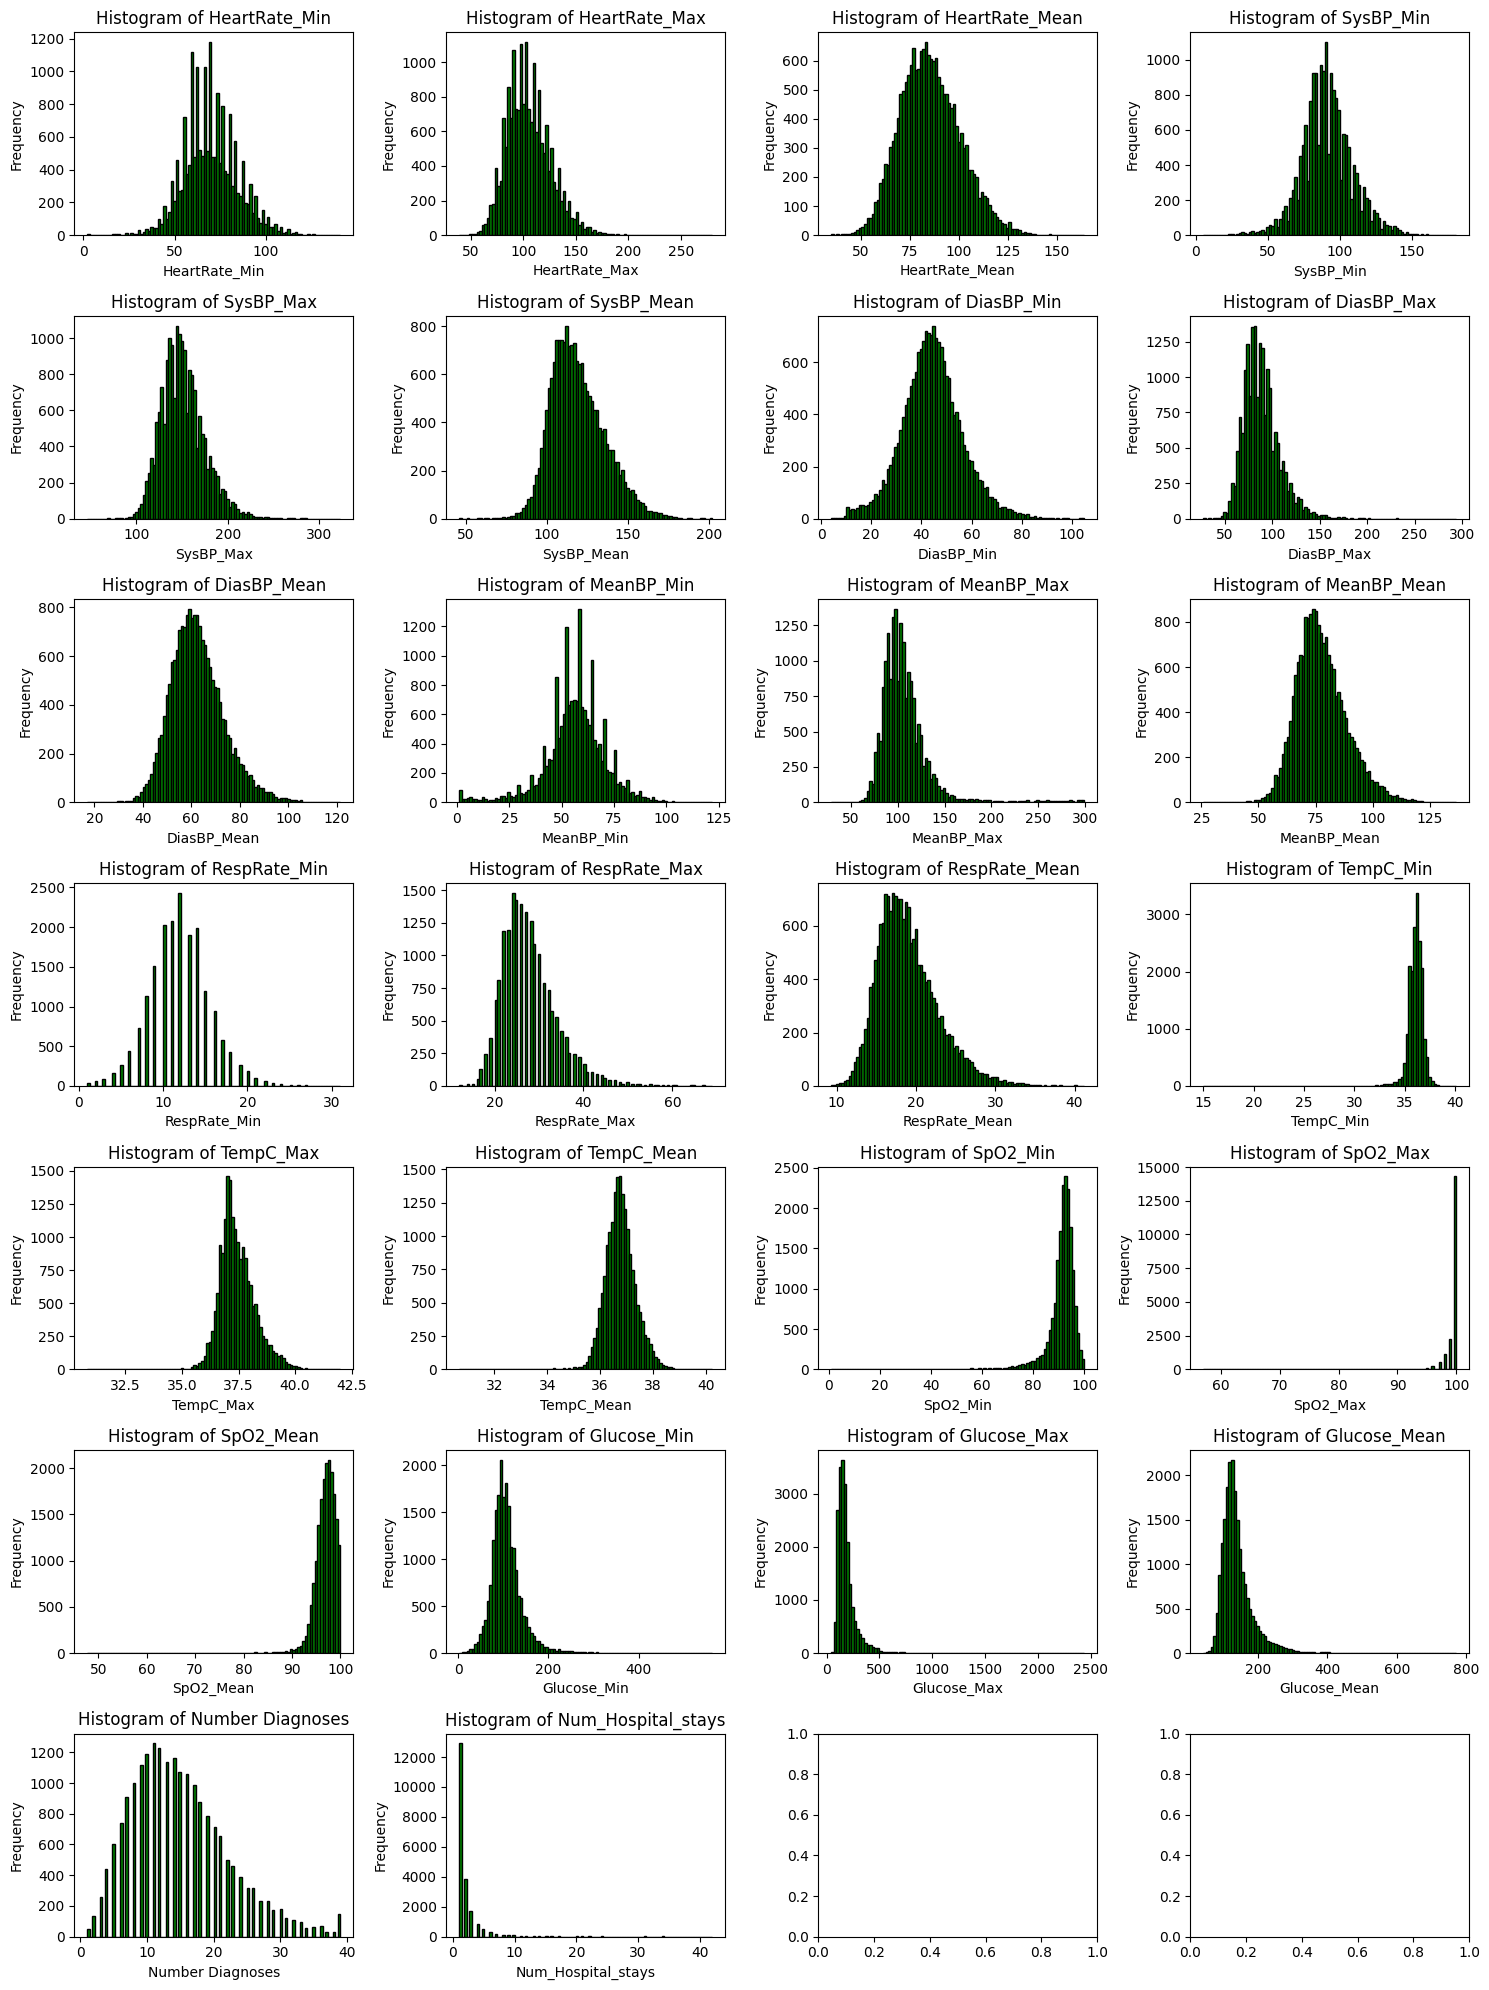

In [39]:
#Create histograms
# Create subplots
fig, axes = plt.subplots(7, 4, figsize=(15, 20))

# Plot histograms for each column
for i, col in enumerate(numerical_continuous):
    row_index = i // 4  # Calculate row index
    col_index = i % 4   # Calculate column index
    
    # Plot histogram
    axes[row_index, col_index].hist(df_train[col], bins=100, color='green', edgecolor='black')
    axes[row_index, col_index].set_xlabel(col)
    axes[row_index, col_index].set_ylabel('Frequency')
    axes[row_index, col_index].set_title(f'Histogram of {col}')  # Use the column name in the title
    axes[row_index, col_index].grid(False)

plt.tight_layout()
plt.show()


In [85]:
#Explore skewness of variables
skewness_dict = {}
for col in numerical_continuous:
   
    non_nan_values = df_train[col].dropna()
    my_skew = skew(non_nan_values)
    skewness_dict[col] = my_skew

print(skewness_dict)

{'HeartRate_Min': 0.200556995031067, 'HeartRate_Max': 0.6626257902618486, 'HeartRate_Mean': 0.3321691758462055, 'SysBP_Min': 0.11741878205233441, 'SysBP_Max': 0.7287900519510719, 'SysBP_Mean': 0.5615753130175963, 'DiasBP_Min': 0.19459331562562548, 'DiasBP_Max': 1.2566917571947622, 'DiasBP_Mean': 0.6027731562308959, 'MeanBP_Min': -0.6032107513981734, 'MeanBP_Max': 3.0908221243416136, 'MeanBP_Mean': 0.60664185728801, 'RespRate_Min': 0.25721166837453413, 'RespRate_Max': 1.2444704802684725, 'RespRate_Mean': 0.9284391987933337, 'TempC_Min': -3.0306005842387784, 'TempC_Max': 0.27321937924679623, 'TempC_Mean': -0.4430440227455398, 'SpO2_Min': -5.002709683613277, 'SpO2_Max': -9.697360068576621, 'SpO2_Mean': -4.551716691754743, 'Glucose_Min': 2.0449242032248542, 'Glucose_Max': 4.057819216263687, 'Glucose_Mean': 2.207770188924157, 'Number Diagnoses': 0.767939844304691, 'Num_Hospital_stays': 6.699090417209229}


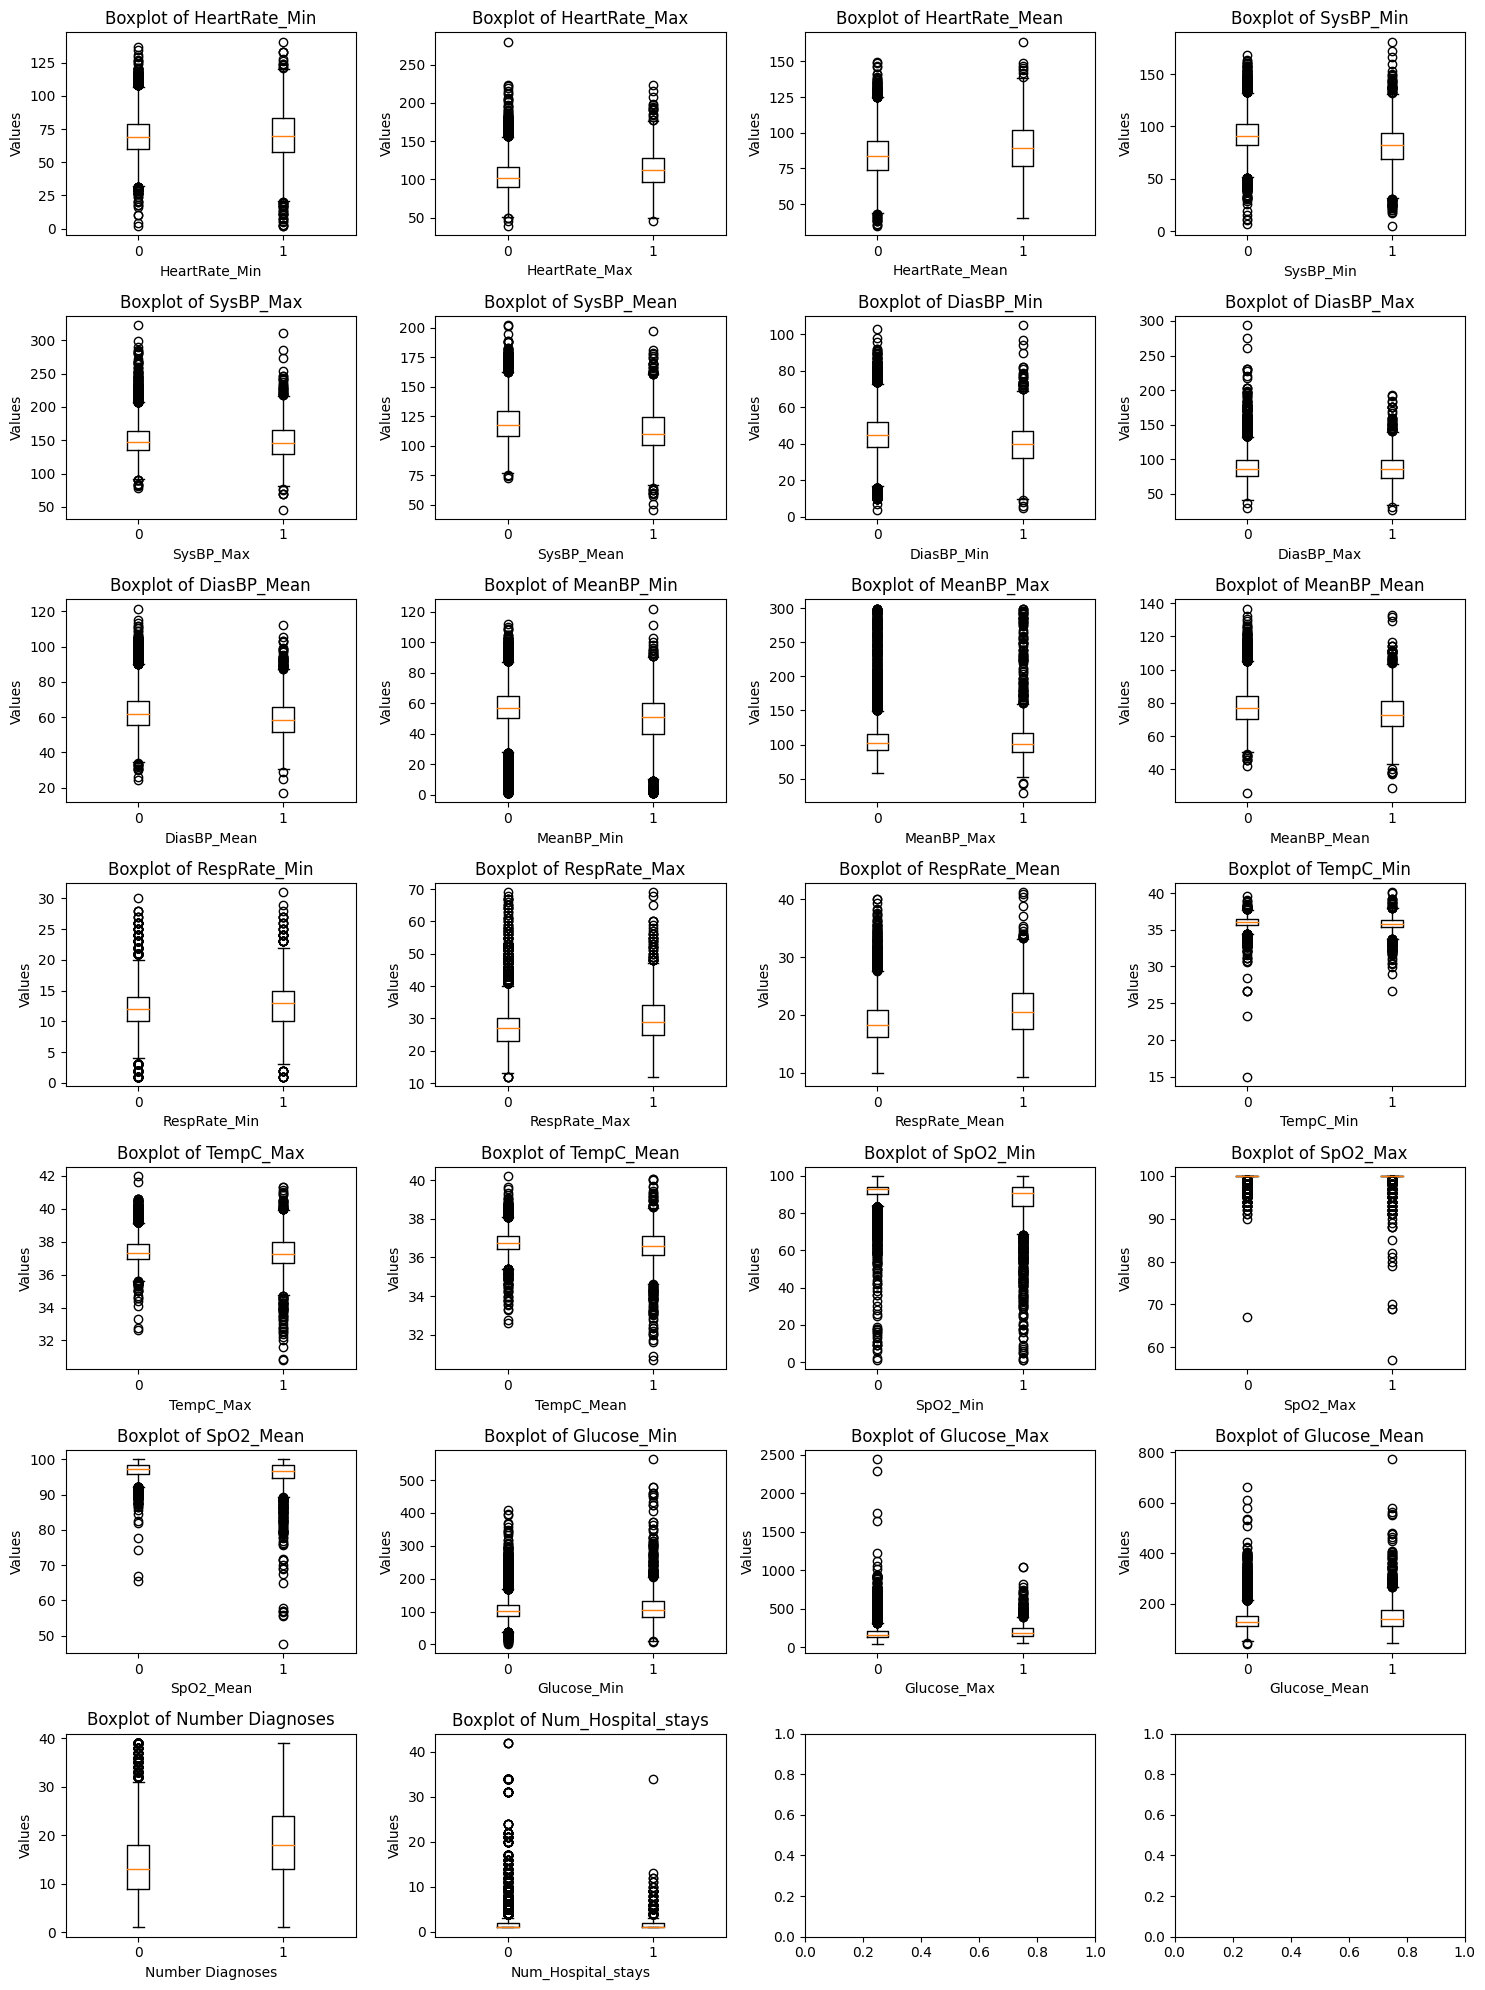

In [32]:
# Create BOXPLOTS of numerical variables conditioning on TARGET VARIABLE
#Create subplots
fig, axes = plt.subplots(7, 4, figsize=(15, 20))

# Group data by hospital_expire_flag
grouped = df_train.groupby('HOSPITAL_EXPIRE_FLAG')

# Plot boxplots for each column
for i, col in enumerate(numerical_continuous):
    row_index = i // 4  
    col_index = i % 4   
    
    # Collect data for boxplots
    boxplot_data = [data[col].dropna().values for _, data in grouped]
    
    # Plot boxplots
    axes[row_index, col_index].boxplot(boxplot_data, labels=['0', '1'])
    
    axes[row_index, col_index].set_xlabel(col)
    axes[row_index, col_index].set_ylabel('Values')
    axes[row_index, col_index].set_title(f'Boxplot of {col}')  
    axes[row_index, col_index].grid(False)


plt.tight_layout()
plt.show()


Regarding histograms, we observe that most of the variables have a quite right or left skew distribution (and most variables with skewness over 0.5 in absolute value) . This is important to consider the NA imputations method. We will not use the mean since it will be influenced by very extreme values. We will consider other methods such as Iterative Imputer or KNN. Moreover, we will standardize numerical continuous variables using the RobustScaler since it is less sentitive to extreme values.

Regarding boxplots, we see that in general there are quite many outliers for most of the variables and for both target variable=0 and =1 (logical after seeing how skewed are distributions). Therefore, we will not treat them for sure using IQR methods and imputing with means (very aggressive in this case). Winsorizing at a 0.05 percentile has been tried but does not seem to improve out of sample predictions so finally they will not be treated, and consider them as part of data distribution.
 

2. CLASS BALANCE OF TARGET VARIABLE

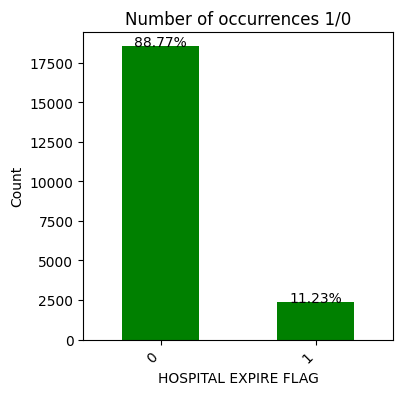

In [33]:
# Assuming you have the position_counts DataFrame
counts = df_train['HOSPITAL_EXPIRE_FLAG'].value_counts()
total_counts = counts.sum()
percentage_1 = (counts[1] / total_counts) * 100
percentage_0 = (counts[0] / total_counts) * 100

# Plot the count of occurrences for each position
plt.figure(figsize=(4, 4))
counts.plot(kind='bar', color='green')

# Add percentages to the plot
plt.text(0, counts[0] + 10, f'{percentage_0:.2f}%', ha='center')
plt.text(1, counts[1] + 10, f'{percentage_1:.2f}%', ha='center')

plt.xlabel('HOSPITAL EXPIRE FLAG')
plt.ylabel('Count')
plt.title('Number of occurrences 1/0')
plt.xticks(rotation=45, ha='right')
plt.show()



We clearly see that the class balance of the target variable is unbalanced. The main problem is the model not to be able to learn from positive death cases and therefore, will be less likely to predict them. 

However, we have tried random over sampling before introducing into the model and it seems to improve cross-validation score but the difference in score with out of sample prediction is quite significative, pointing to possible overfitting. For SVM, class_weight=balanced parameter is used to tackle class imbalance.

3. CORRELATION BETWEEN VARIABLES

In [15]:
numerical_continuous_target=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Number Diagnoses', 'Num_Hospital_stays', 'HOSPITAL_EXPIRE_FLAG']

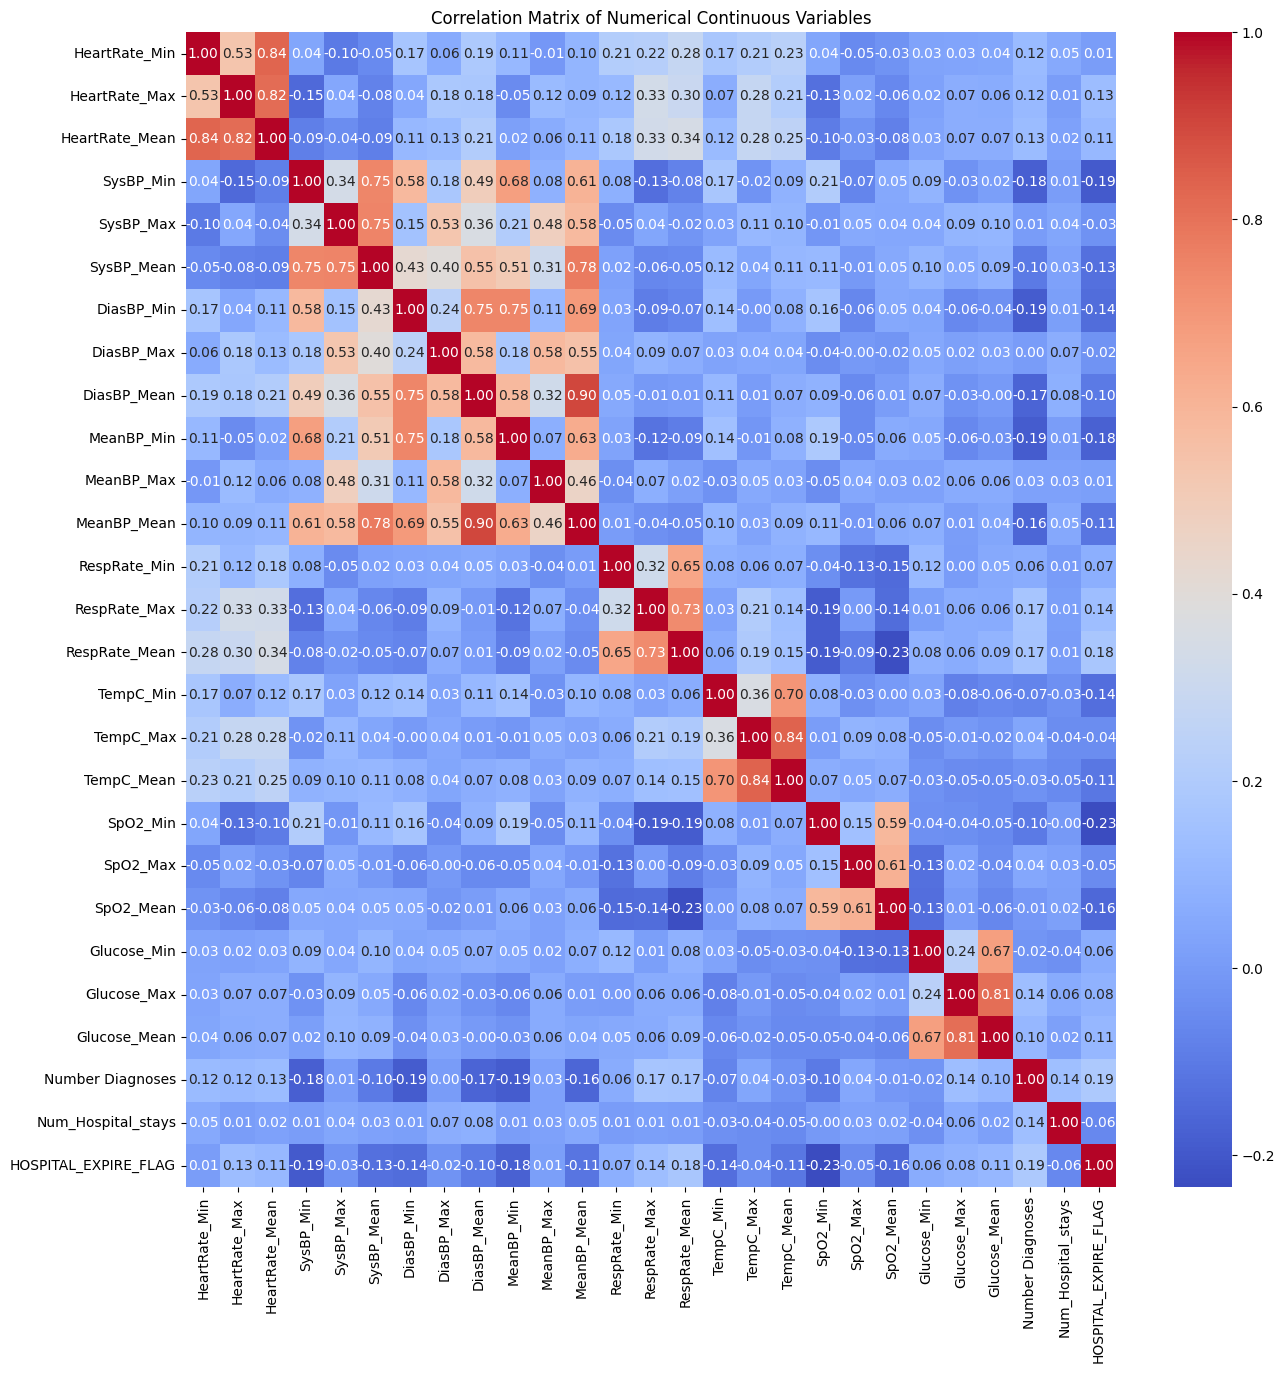

In [19]:
numerical_continuous_df = df_train[numerical_continuous_target]
corr = numerical_continuous_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Continuous Variables')
plt.show()

Regarding correlations, we do not observe any particular variable with a stronger correlation with the target variable than others. All of them are around 0.10-0.22. 

Between other numerical variables wee see logical correlation between mean, min and max of the same vital signs whcih seems logic.Moreover, within SySBP, DiaspBP and Mean BP all related to blood pressure. Given this, we will run the model with kbest selection features to reduce dimensionality and remove redundant features. 

Regarding categorical variables, once we encoded them, we will plot the correlation feature to check for correlation.

4. CHECK MISSING VALUES

We explore quantity of missing values and which variables have them.

In [148]:
missing_percentages = df_train.isnull().sum() / len(df_train) * 100

In [149]:
# Filter missing percentages for columns that start with "ICD9"
icd9_missing_percentages = missing_percentages.loc[missing_percentages.index.str.startswith('ICD9')]

print("Missing percentages for columns starting with 'ICD9':")
print(icd9_missing_percentages.sort_values(ascending=False))
print()

# Filter missing percentages for columns that do not start with "ICD9"
non_icd9_missing_percentages = missing_percentages.loc[~missing_percentages.index.str.startswith('ICD9')]

print("Missing percentages for columns not starting with 'ICD9':")
print(non_icd9_missing_percentages.sort_values(ascending=False))


Missing percentages for columns starting with 'ICD9':
ICD9_CODE_39      99.291357
ICD9_CODE_38      99.142926
ICD9_CODE_37      98.984917
ICD9_CODE_36      98.649749
ICD9_CODE_35      98.362461
ICD9_CODE_34      98.079962
ICD9_CODE_33      97.620302
ICD9_CODE_32      97.084032
ICD9_CODE_31      96.514245
ICD9_CODE_30      95.642806
ICD9_CODE_29      94.804884
ICD9_CODE_28      93.708403
ICD9_CODE_27      92.597558
ICD9_CODE_26      91.089299
ICD9_CODE_25      89.585827
ICD9_CODE_24      87.737611
ICD9_CODE_23      85.539861
ICD9_CODE_22      83.145798
ICD9_CODE_21      80.038305
ICD9_CODE_20      76.610007
ICD9_CODE_19      72.856117
ICD9_CODE_18      68.661719
ICD9_CODE_17      63.931051
ICD9_CODE_16      58.874791
ICD9_CODE_15      53.741920
ICD9_CODE_14      48.182906
ICD9_CODE_13      42.738808
ICD9_CODE_12      36.878142
ICD9_CODE_11      30.854680
ICD9_CODE_10      25.147235
ICD9_CODE_9       19.794111
ICD9_CODE_8       15.015561
ICD9_CODE_7       10.677520
ICD9_CODE_6        7.1

Most of the columns of ICD9_Code will be dropped (NA> 50%) since most of the patients do not have more than 15 diagnoses in a hospitalizations. We  we will Target encode these variables, therefore, we decide to drop those with high percentage of NA not to get the columns filled with more than 50% of values in these columns that are "made up" which will be giving a certain mortality rate to a diagnose that patients did not actually have.

In [150]:
#Drop if any, columns with missing values above 50%
threshold=50
missing_percentages = df_train.isnull().sum() / len(df_train)* 100
columns_to_drop = missing_percentages[missing_percentages >= threshold].index
print(columns_to_drop)

Index(['ICD9_CODE_15', 'ICD9_CODE_16', 'ICD9_CODE_17', 'ICD9_CODE_18',
       'ICD9_CODE_19', 'ICD9_CODE_20', 'ICD9_CODE_21', 'ICD9_CODE_22',
       'ICD9_CODE_23', 'ICD9_CODE_24', 'ICD9_CODE_25', 'ICD9_CODE_26',
       'ICD9_CODE_27', 'ICD9_CODE_28', 'ICD9_CODE_29', 'ICD9_CODE_30',
       'ICD9_CODE_31', 'ICD9_CODE_32', 'ICD9_CODE_33', 'ICD9_CODE_34',
       'ICD9_CODE_35', 'ICD9_CODE_36', 'ICD9_CODE_37', 'ICD9_CODE_38',
       'ICD9_CODE_39'],
      dtype='object')


In [151]:
# Drop the columns from the concatenated DataFrame
df_train.drop(columns_to_drop, axis=1, inplace=True)

In [152]:
df_test.drop(columns_to_drop, axis=1, inplace=True)

Regarding the missing values of the rest of vital signs, we see most of them happen within the same observation. That is, one observation of a hospitalization of a subject ID might have all the vital signs empty. This makes difficult to impute NA with non-linear methods such as KNN given that those observations have not other vital signs, so it is difficult to find 'good neighbors' assuming that probably, vital signs are more reliably predictive of missing vital signs than categorical variables such as Marital status.
This has been prooved empirically, trying KNN does not give as good results as Iterative Imputer.

Regarding the only categorical variable with missing values (MARITAL STATUS), NA will be imputed to the category of UNKNOWN.

## 4. PREPROCESSING OF CATEGORICAL VARIABLES 

We see most of the categorical variables have many different categories so we will try group them in fewer groups and then do either OneHot Econding or Binary Encoding for high cardinality features, not to add too many columns.

A) ENCODING RELIGION

In [44]:
df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64

In [153]:
#Group Different religion categories in only 4 based on main groups observed
def encode_religion(religion):
    if "CATHOLIC" in religion:
        return "CATHOLIC"
    elif "PROTESTANT" in religion:
        return "PROTESTANT"
    elif "JEWISH" in religion:
        return "JEWISH"
    elif "MUSLIM" in religion:
        return "MUSLIM"
    else:
        return "OTHER"

df_train['RELIGION_TO_ENCODE'] = df_train['RELIGION'].apply(encode_religion)
df_test['RELIGION_TO_ENCODE'] = df_test['RELIGION'].apply(encode_religion)

B) ENCODING MARITAL STATUS

In [46]:
df_train['MARITAL_STATUS'].value_counts()

MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: count, dtype: int64

In [154]:
#Fill NA with Unknown category given that it is alredy present
df_train['MARITAL_STATUS']=df_train['MARITAL_STATUS'].fillna("UNKNOWN (DEFAULT)")
df_test['MARITAL_STATUS']=df_test['MARITAL_STATUS'].fillna("UNKNOWN (DEFAULT)")

In [155]:
#Group similar categories into one
def encode_marital_status(status):
    if "LIFE PARTNER" in status:
        return "MARRIED"
    elif "DIVORCED" in status:
        return "SEPARATED"
    else:
        return status

df_train['MARITAL_STATUS_TO_ENCODE'] = df_train['MARITAL_STATUS'].apply(encode_marital_status)
df_test['MARITAL_STATUS_TO_ENCODE'] = df_test['MARITAL_STATUS'].apply(encode_marital_status)


C) ENCODING ETHNICITY

In [49]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58


In [156]:
#Group ethnicity into principal groups according to observed categories and group minorities into "OTHER"
def encode_ethnicity(ethnicity):
    if "WHITE" in ethnicity:
        return "WHITE"
    elif "HISPANIC" in ethnicity:
        return "HISPANIC/LATINO"
    elif "ASIAN" in ethnicity:
        return "ASIAN"
    elif "BLACK" in ethnicity:
        return "BLACK"
    else:
        return "OTHER"

df_train['ETHNICITY_TO_ENCODE'] = df_train['ETHNICITY'].apply(encode_ethnicity)
df_test['ETHNICITY_TO_ENCODE'] = df_test['ETHNICITY'].apply(encode_ethnicity)


D) GENDER, FIRST CAREUNIT AND ADMISSION TYPE

In [52]:
df_train['GENDER'].value_counts()

GENDER
M    11759
F     9126
Name: count, dtype: int64

In [27]:
df_train['FIRST_CAREUNIT'].value_counts()

FIRST_CAREUNIT
MICU     8640
SICU     3961
CSRU     3127
TSICU    2645
CCU      2512
Name: count, dtype: int64

In [28]:
#ADMISSION TYPE
df_train['ADMISSION_TYPE'].value_counts()

ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: count, dtype: int64

These three last variables are not considered to be grouped because of its relatively low cardinality and with no redundant groups.

Once categorical have been encoded into fewer groups, they will be one hot or binary encoded. Admission type and Gender are one hote encoded given the few categories. The rest will be encoded using binary encoding not to get too many additional columns.

ONE HOT ENCODING OF ADMISSION TYPE AND GENDER

In [157]:
encoder_OHE = ce.OneHotEncoder(cols=['ADMISSION_TYPE', 'GENDER'],return_df=True)
df_train=encoder_OHE.fit_transform(df_train)
df_test=encoder_OHE.fit_transform(df_test)

BINARY ENCODING OF MARITAL STATUS, ETHNICITY, RELIGION, INSURANCE AND FIRST CARE UNIT

In [158]:
encoder_binary = ce.BinaryEncoder(cols=['MARITAL_STATUS_TO_ENCODE', 'ETHNICITY_TO_ENCODE', 'RELIGION_TO_ENCODE', 'INSURANCE', 'FIRST_CAREUNIT'],return_df=True)
df_train=encoder_binary.fit_transform(df_train)
df_test=encoder_binary.fit_transform(df_test)

We drop the initial variables that have been encoded plus DIAGNOSIS given that this variable it is just the name of the diagnosis and do not give any value added.

In [159]:
#Drop the initial variables that have been encoded plus 'Diagnosis'
df_train=df_train.drop(columns=['RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS'])
df_test=df_test.drop(columns=['RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS'])

E) AGE

Given that we have Date of Birth and Admission time, using DIFF col, Age of Admission is computed and will be used as a variable to include in the model.

A function is used to convert input variables to date format. Year of Admission and Year of Birth are computed, and the new variable "Age of Admission", equal to the difference of the latter, is added.

In [160]:

def calculate_age(df, admit_col, dob_col, diff_col):
    df[admit_col] = pd.to_datetime(df[admit_col]) 
    df[dob_col] = pd.to_datetime(df[dob_col])
    df['Diff'] = pd.to_timedelta(df[diff_col], unit='D')

    # Calculate Year of Admission
    df[admit_col] = df[admit_col] + df['Diff']
    df[admit_col] = df[admit_col].dt.year

    # Calculate Year of Birth
    df[dob_col] = df[dob_col] + df['Diff']
    df[dob_col] = df[dob_col].dt.year

    # Calculate Age of Patient on AdmissionDate
    df['Age_Admission'] = df[admit_col] - df[dob_col]

    return df

In [161]:
#Apply function to df_train
df = calculate_age(df_train, 'ADMITTIME', 'DOB', 'Diff')
df_train=df

In [162]:
#Apply function to df_test
df = calculate_age(df_test, 'ADMITTIME', 'DOB', 'Diff')
df_test=df

We check the distribution of Age Related variables to explore this new feature and we see that there are some outliers that have a date of birth in 1700, probably wrong.

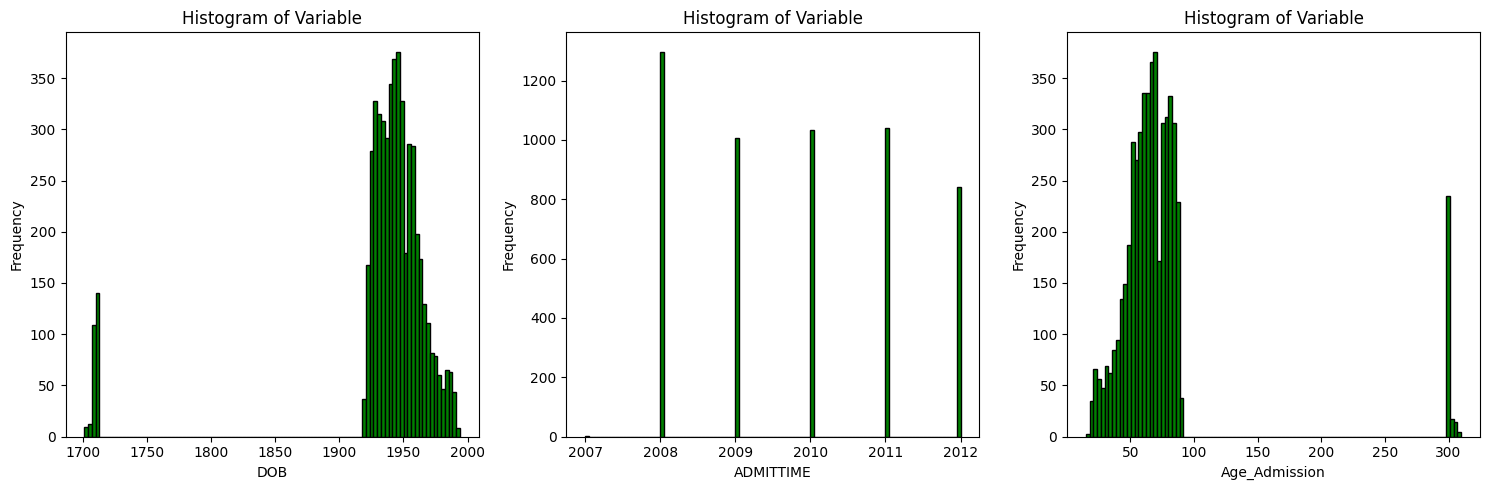

In [366]:
age_related_columns=['DOB', 'ADMITTIME', 'Age_Admission']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(age_related_columns):   
    axes[i].hist(df_test[col], bins=100, color='green', edgecolor='black')  
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title('Histogram of Variable')
    axes[i].grid(False)
    
plt.tight_layout()
plt.show()

It seems like observations that have an unusual DOB are the same with resulting unusual AGE Admission but we check if these are the same and do not come from "Diff" variable.

In [163]:
#Define outliers for DOB
old_people_test=df_test[(df_test['DOB']<1900)]
old_people_train=df_train[(df_train['DOB']<1900)]

#Define outliers for Age_Admission
old_age_admission_test=df_test[(df_test['Age_Admission']>150)]
old_age_admission_train=df_train[(df_train['Age_Admission']>150)]

# Extracting Subject IDs from each case
ids_old_people_test = set(old_people_test['subject_id'])
ids_old_people_train = set(old_people_train['subject_id'])
ids_old_age_admission_test = set(old_age_admission_test['subject_id'])
ids_old_age_admission_train = set(old_age_admission_train['subject_id'])

# Checking whether Subject IDs are the same between DataFrames
if (ids_old_people_test == ids_old_age_admission_test) & (ids_old_people_train == ids_old_age_admission_train):
    print("Subject IDs are the same in all DataFrames.")
else:
    print("Subject IDs are not the same in all DataFrames.")


Subject IDs are the same in all DataFrames.


Since these are the same, we treat directly Age of Admission to correct for these irregularities. In Github it is said that in the mimic dataset II, patients with an Age of Admission above 89 have been given a random DOB for privacy issues. Therefore, these outliers will be assigned a random Age of Admission between 90 and 101, for example, which seems a reasonable max range of Hospital Admission.
If this information hadn't been available, the outliers would have been imputed adding to their DOB, the average difference of DOB between outliers and non outliers from df_train.

In [164]:
#Define outliers
outliers_train = df_train['Age_Admission'] > 100
outliers_test = df_test['Age_Admission'] > 100

#Impute with a random number between 90 and 101 to both train and test
imputed_values_train = np.random.randint(90, 101, size=outliers_train.sum())
df_train.loc[outliers_train, 'Age_Admission'] = imputed_values_train

imputed_values_test = np.random.randint(90, 101, size=outliers_test.sum())
df_test.loc[outliers_test, 'Age_Admission'] = imputed_values_test

The histogram for Age of Admission is plotted again to check for correct imputation of these outliers.

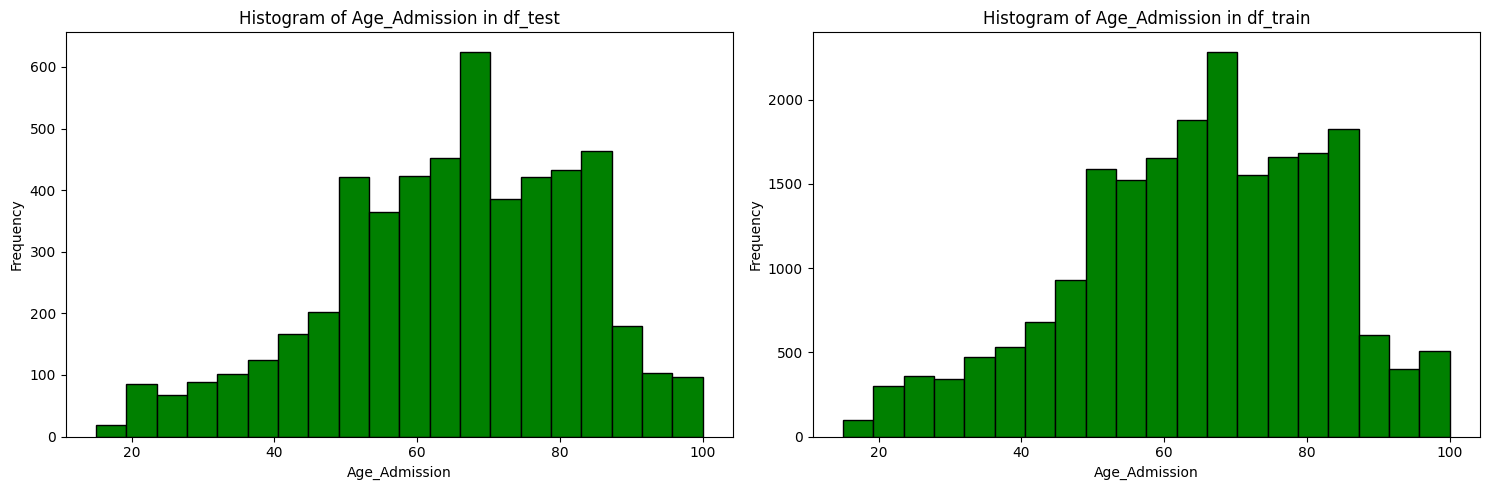

In [62]:
# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for df_test
axes[0].hist(df_test['Age_Admission'], bins=20, color='green', edgecolor='black')
axes[0].set_xlabel('Age_Admission')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Age_Admission in df_test')
axes[0].grid(False)

# Plot for df_train
axes[1].hist(df_train['Age_Admission'], bins=20, color='green', edgecolor='black')
axes[1].set_xlabel('Age_Admission')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Age_Admission in df_train')
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [165]:
#Drop initial age-related variables
df_train=df_train.drop(columns=['ADMITTIME', 'Diff', 'DOB'])
df_test=df_test.drop(columns=['ADMITTIME', 'Diff', 'DOB'])

F) ICD9 DIAGNOSIS

Regarding the ICD9 diagnosis variable, it will be target encoded based on the Hospital Expire Flag, that is, 
imputing the mean of mortality of that code in each sequence. 

A small smoothing value directs encoding towards the overall mean of the target variable which in this case it is small so it will not allow more specific relationships between diagnose and death to arise. However a large smoothing parameter will produce overfitting. If there is only one observation of a diagnose, it will have a mean of 1 or 0, but it might not be reliably extrapolable to other out of sample.

Cross Validation have not been carried out to determine the optimal parameter but the parameter has been chosen out of trial/error ensuring that in sample roc_auc was similar to out of sample roc_auc(Kaggle). After some trials, parameter 10 seems to work well.


In [166]:
#Drop variable from initial dataset which is equivalent to the first column added from extra data
df_train=df_train.drop(columns=['ICD9_diagnosis'])
df_test=df_test.drop(columns=['ICD9_diagnosis'])

In [167]:
#Initialize Target Encoder
ICD9_encoder = TargetEncoder(smoothing=10)

In [168]:
#Fit Encoder to df_train and transform df_test with same encoder
for col in df_train.columns:
    if col.startswith('ICD9_'):
        df_train[f'{col}_encoded'] = ICD9_encoder.fit_transform(df_train[col], df_train['HOSPITAL_EXPIRE_FLAG'])
        df_test[f'{col}_encoded'] = ICD9_encoder.transform(df_test[col])

In [169]:
#Drop initial variables
df_train=df_train.drop(columns=['ICD9_CODE_1', 'ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4',
       'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8',
       'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12',
       'ICD9_CODE_13', 'ICD9_CODE_14'])
df_test=df_test.drop(columns=['ICD9_CODE_1', 'ICD9_CODE_2', 'ICD9_CODE_3', 'ICD9_CODE_4',
       'ICD9_CODE_5', 'ICD9_CODE_6', 'ICD9_CODE_7', 'ICD9_CODE_8',
       'ICD9_CODE_9', 'ICD9_CODE_10', 'ICD9_CODE_11', 'ICD9_CODE_12',
       'ICD9_CODE_13', 'ICD9_CODE_14'])

G) EXPLORE CORRELATION BETWEEN CATEGORICAL VARIABLES

In [83]:
cat_variables=['GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2',
       'RELIGION_TO_ENCODE_0',
       'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded', 'HOSPITAL_EXPIRE_FLAG']

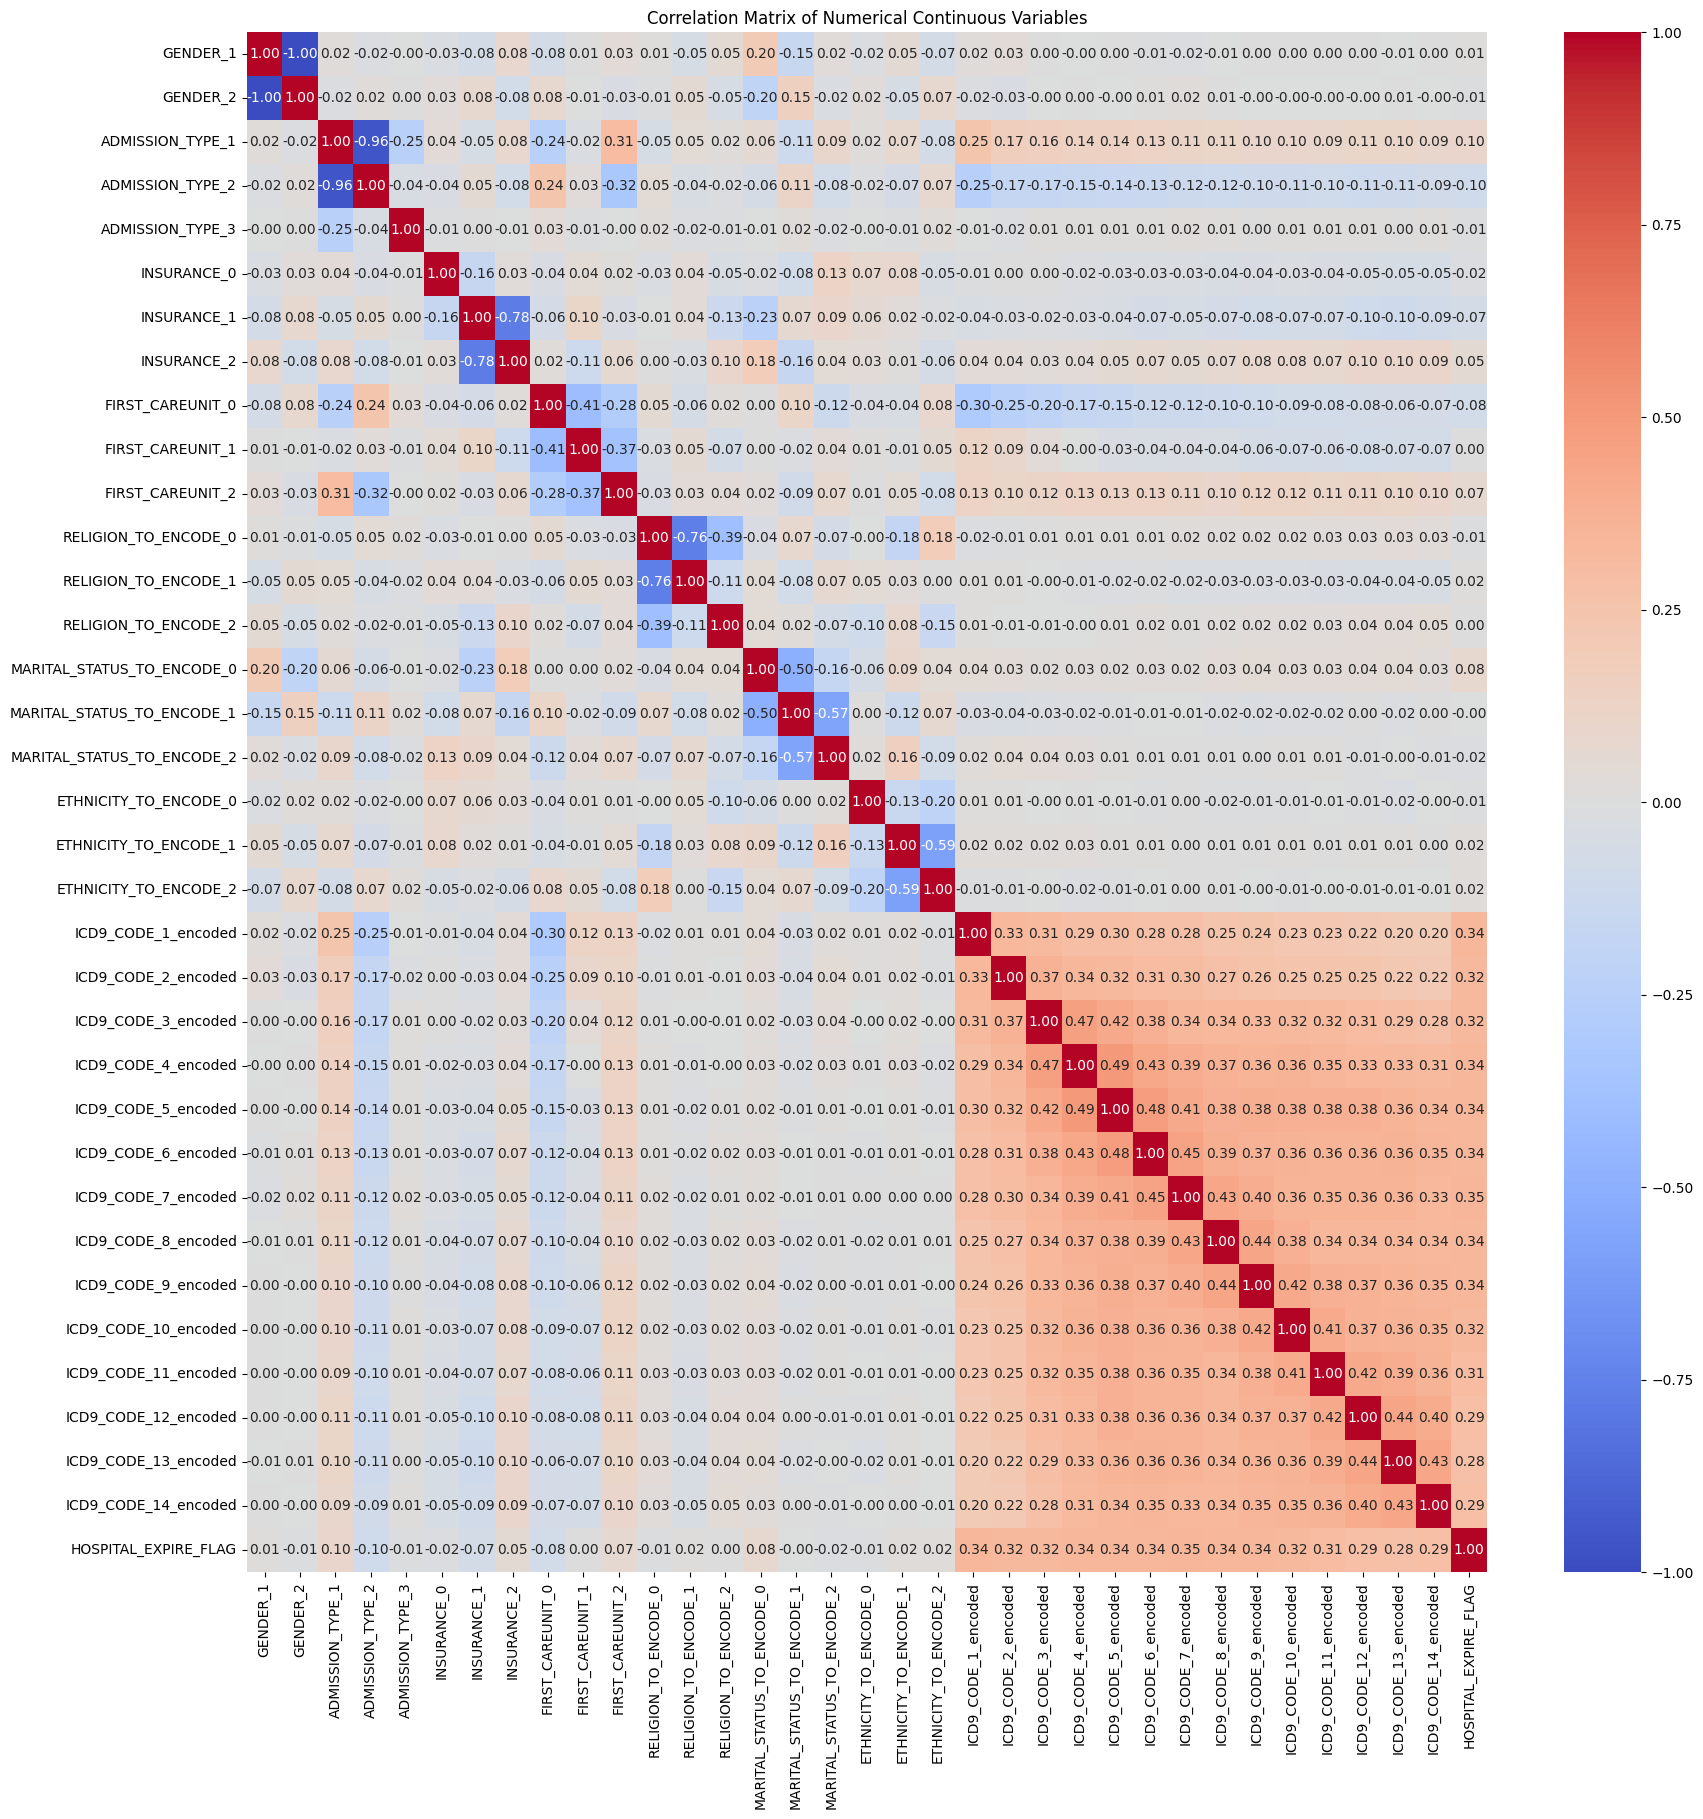

In [84]:

cat_variables_df = df_train[cat_variables]
corr = cat_variables_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Continuous Variables')
plt.show()

Regarding the target variable, we see that it has a higher correlation with the ICD9_CODE type of variables, that is, those that are targeted with mean of mortality, as expected. 
Beyond these, we do not obser a significant correlation with any of the other categorical variables.
Among other variables, we see of course a significant correlation between de ICD9 variables. Other than that, other high correlation are only found between categorical columns of the same category (i.e, MARITAL STATUS 2 AND MARITAL STATUS 1).
Given that we are using selectKbest in the model trainning, we expect that not all dummies from a single category will be taken.

## 5. PREPROCESSING OF NUMERICAL VARIABLES

In this section, NAS of numerical variables (vital signs) will be imputed using Iterative Imputer. Since we have variables with different scale (vital signs, ICD9 encoded, dummy variables, etc) we will standardize first and after imputation, they will be scaled ready to be inputed to the model. 
We use RobustScalar for continuous variables given to the skewed distribution of most of them. For binary variables Standard Scalar is used.

A) SCALING DATA

In [170]:
numerical_continuous_robust=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Number Diagnoses', 'Num_Hospital_stays', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded', 'ICD9_CODE_4_encoded', 
       'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded', 'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 
       'ICD9_CODE_9_encoded', 'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded', 
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']



In [174]:
numerical_binary_scalar=['GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2']

In [172]:
#Fit a Robustscaler to the continuous features in the training set and transform them
RS = RobustScaler()
RS.fit(df_train[numerical_continuous_robust])
robust_scaled_train_features = RS.transform(df_train[numerical_continuous_robust])

# Apply the same scaler to the continuous features in the test set
robust_scaled_test_features = RS.transform(df_test[numerical_continuous_robust])

# Update the DataFrame with scaled features for both train and test sets
df_train[numerical_continuous_robust] = robust_scaled_train_features
df_test[numerical_continuous_robust] = robust_scaled_test_features

In [175]:
#Fit a Standardscaler to the continuous features in the training set and transform them
scaler = StandardScaler()
scaler.fit(df_train[numerical_binary_scalar])
scaled_train_features = scaler.transform(df_train[numerical_binary_scalar])

# Apply the same scaler to the continuous features in the test set
scaled_test_features = scaler.transform(df_test[numerical_binary_scalar])

# Update the DataFrame with scaled features for both train and test sets
df_train[numerical_binary_scalar] = scaled_train_features
df_test[numerical_binary_scalar] = scaled_test_features

B) IMPUTING NAs

As commented before, KNN imputer has been tried but does not seem to work well. We have observed that NAs are present in all vital signs of many observations, therefore, it might be that KNN cannot predict well missing values. We try iterativeImputer and it seems to be performing well.
For iterativeimputer, the default estimator "BayesianRidge" is chosen as default option. The intial strategy is set to 'median' given the skewness of most of the numerical variables for which we have NAs. Max iteration is set to 15 as limit rounds if convergence is not reached. 

In [176]:
#Initialize Iterative impute
imputer_missing_values = IterativeImputer(estimator=BayesianRidge(), max_iter=10, initial_strategy='median', random_state=0)

In [177]:
#Fit and tranform Train data 
df_train[numerical_continuous_robust] = imputer_missing_values.fit_transform(df_train[numerical_continuous_robust]) 

In [178]:
#Transform Test Data
df_test[numerical_continuous_robust] = imputer_missing_values.transform(df_test[numerical_continuous_robust])

## 6. TRAIN KNN MODEL

In [179]:
#Define X_train, Y_train set and X_test set
X_train=df_train[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']]

y_train=df_train[['HOSPITAL_EXPIRE_FLAG']]

X_target=df_test[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']]

A Pipeline is created to do grid search over different parameters. The steps initiated are feature selection with SelectKBest and KNN Classifier. 
Regarding Kbest parameters, the range of number of features over which to choose is set between 10 and 60. 
For KNN parameters, we set algorithm to be 'brute' since it is the one comparing neighbor to neighbor and even if it is computationally expensive, in this case is manageable.  
As a number of neighbors, a range between 50 and 500 is set. As type of weight, uniform and distance, although we expect distance to perform better in most of the cases since it gives more weights to closest neighbors.

In [194]:

"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [10, 15, 20, 25, 30, 35, 40, 50, 60],  
    'knn__n_neighbors': [50, 100, 200, 300, 400, 500],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm':['brute']      
}

grid_knn_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)
grid_knn_acc.fit(X_train, y_train)
print("Best parameters:", grid_knn_acc.best_params_)
print("Best Score:", grid_knn_acc.best_score_)"""

Best parameters: {'feature_selection__k': 10, 'knn__algorithm': 'brute', 'knn__n_neighbors': 100, 'knn__weights': 'distance'}
Best Score: 0.9326276382499298


We get the following results: 
Best parameters: {'feature_selection__k': 10, 'knn__algorithm': 'brute', 'knn__n_neighbors': 100, 'knn__weights': 'distance'}.

Best Score: 0.9326276382499298.

Therefore, another Pipeline is set with a narrower range and setting algorithm=brute and weights=distance already in the KNNClassifier.


In [195]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier(algorithm='brute', weights='distance'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [8, 9, 10, 11, 12, 13, 14],  
    'knn__n_neighbors': [50, 55, 60, 70, 75, 80],     
}

grid_knn_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)
grid_knn_acc.fit(X_train, y_train)
print("Best parameters:", grid_knn_acc.best_params_)
print("Best Score:", grid_knn_acc.best_score_)"""

Best parameters: {'feature_selection__k': 14, 'knn__n_neighbors': 80}
Best Score: 0.9385998844990399


The following result is obtained:

Best parameters: {'feature_selection__k': 14, 'knn__n_neighbors': 80}.

Best Score: 0.9385998844990399.

Therefore, another Pipeline is run since values in the limits of the ranges are being obtained.

In [197]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier(algorithm='brute', weights='distance'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [12, 13, 14, 17, 20, 25],  
    'knn__n_neighbors': [80, 100, 120, 140, 150],     
}

grid_knn_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)
grid_knn_acc.fit(X_train, y_train)
print("Best parameters:", grid_knn_acc.best_params_)
print("Best Score:", grid_knn_acc.best_score_)"""

Best parameters: {'feature_selection__k': 14, 'knn__n_neighbors': 120}
Best Score: 0.9395718248448489



From this last GridSearch, the following is obtained.
Best parameters: {'feature_selection__k': 14, 'knn__n_neighbors': 120}.

Best Score: 0.9395718248448489.

The model is trained with such features. 

In [198]:

MyKNN = KNeighborsClassifier(n_neighbors=120, algorithm='brute', weights='distance')

selector = SelectKBest(score_func=f_classif, k=14)
X_train_selected = selector.fit_transform(X_train, y_train)

MyKNN.fit(X_train_selected, y_train)


KNeighborsClassifier(algorithm='brute', n_neighbors=120, weights='distance')

The selected features from KBest are printed below:

In [199]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

X_train=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']
# Get the names of the selected features from custom feature names
selected_feature_names = [X_train[i] for i in selected_feature_indices]

# Print the names of the selected features
print("Names of selected features:", selected_feature_names)

Names of selected features: ['ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded', 'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded', 'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded', 'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded', 'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']


In [200]:
#Apply selectKbest to X_target 
X_target_selected = selector.transform(X_target)

In [201]:
#Produce predictions (1/0 and probabilities)
target_pred_2 = MyKNN.predict(X_target_selected)
target_proba_2 = MyKNN.predict_proba(X_target_selected)

In [203]:
# Sample output prediction file
prediction_data=pd.read_csv(r'C:\Users\julia\OneDrive\Documentos\DSDM\2nd TERM\Computational Learning\DL_materials\project\dl24-probability-of-death-with-k-nn\mimic_kaggle_death_sample_submission.csv')

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0
4908,200044,0
829,200049,0
4378,200063,0
4946,200081,0


In [204]:
# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": target_proba_2[:,1]})
test_predictions_submit.to_csv("test_predictions_submit_KNN_2.csv", index = False)

## 7. TRAIN SVC MODEL

For SVC, similar procedures to KNN will be followed. 
However, two different gridsearches will be performed based on two different kernels (lineal and rbf) given that one gridsearch for the two of them, even if using the subset, was computationally expensive.

In [245]:
#Define X_train, Y_train set and X_test set
X_train=df_train[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']]

y_train=df_train[['HOSPITAL_EXPIRE_FLAG']]

X_target=df_test[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']]

In [206]:
# Subsetting X_train and y_train to include only 2000 observations
X_train_subset = X_train.iloc[:2000]
y_train_subset = y_train.iloc[:2000]

7.1. LINEAR KERNEL

A pipeline with feature selection and SVC with kernel='linear' and class_weight=balanced is created. Class_weight=balanced is chosen given that we have an imbalanced dataset. This helps putting more weight to minor classes (Target Variable=1 in our case) to improve model's performance specially for these classes.
As a parameters for selectkbest, a range between 10-60 features is considered. 
Other svc parameters considering linear Kernel is C which is the regularization parameter. The default is one, and we select a range between 0.2 and 1.2 as starting point.

In [222]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [10, 20, 25, 30, 35, 40, 50, 60],  
    'svc__C': [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
    'svc__kernel':['linear']}
grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)"""

Best parameters: {'feature_selection__k': 30, 'svc__C': 0.6, 'svc__kernel': 'linear'}
Best Score: 0.9412798987061628


From the first GridSearch, the following output is obtained.

Best parameters: {'feature_selection__k': 30, 'svc__C': 0.6, 'svc__kernel': 'linear'}.

Best Score: 0.9412798987061628.

Another GridSearch is performed narrowing down the parameters.


In [224]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [26, 27, 28, 29, 30, 31, 32, 33, 34],  
    'svc__C': [0.5, 0.55, 0.6, 0.65, 0.7],
    'svc__kernel':['linear']}
grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)"""

Best parameters: {'feature_selection__k': 30, 'svc__C': 0.55, 'svc__kernel': 'linear'}
Best Score: 0.9413745956758598


From the last Grid Search, the following output is obtained.

Best parameters: {'feature_selection__k': 30, 'svc__C': 0.55, 'svc__kernel': 'linear'}.

Best Score: 0.9413745956758598.

The final model is trainned on these parameters.


In [227]:

MySvC = SVC(C=0.55, kernel='linear', probability=True)
selector = SelectKBest(score_func=f_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
MySvC.fit(X_train_selected, y_train)

SVC(C=0.55, kernel='linear', probability=True)

In [228]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

X_train=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']
# Get the names of the selected features from custom feature names
selected_feature_names = [X_train[i] for i in selected_feature_indices]

# Print the names of the selected features
print("Names of selected features:", selected_feature_names)

Names of selected features: ['HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Mean', 'DiasBP_Min', 'MeanBP_Min', 'MeanBP_Mean', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Mean', 'SpO2_Min', 'SpO2_Mean', 'Glucose_Mean', 'Number Diagnoses', 'Age_Admission', 'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded', 'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded', 'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded', 'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded', 'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']


In [229]:
#Apply selector to X_target
X_target_selected = selector.transform(X_target)

In [216]:
#Make predictions (binary and probability)
y_pred_acc = MySvC.predict(X_target_selected)
y_pred_acc_proba = MySvC.predict_proba(X_target_selected)

In [230]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_pred_acc_proba[:,1]})
test_predictions_submit.to_csv("test_predictions_submit_SVM.csv", index = False)

7.2 RBF kernel

In [232]:

"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced', kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [15, 20, 30, 40, 50, 60],  # Number of features to select
    'svc__C': [0.4, 0.6, 0.8, 1],
    'svc__gamma':[0.00005, 0.0001, 0.005],
    }



grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)"""

Best parameters: {'feature_selection__k': 30, 'svc__C': 1, 'svc__gamma': 0.005}
Best Score: 0.9380240253660197


The output from the previus GridSearch is the following.
Best parameters: {'feature_selection__k': 30, 'svc__C': 1, 'svc__gamma': 0.005}.

Best Score: 0.9380240253660197.

We run another Gridsearch narrowing down the parameters.


In [234]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced', kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [26, 28, 30, 32, 34],  # Number of features to select
    'svc__C': [0.9, 1, 2, 3],
    'svc__gamma':[0.005, 0.01, 0.05],
    }

grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)"""

Best parameters: {'feature_selection__k': 30, 'svc__C': 3, 'svc__gamma': 0.005}
Best Score: 0.9392215696288728


From the previous GridSearch, the following output is obtained: 
Best parameters: {'feature_selection__k': 30, 'svc__C': 3, 'svc__gamma': 0.005}.

Best Score: 0.9392215696288728.

Another GridSearch is run narrowing down the parameters.


In [238]:
"""pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced', kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [29, 30, 31, 32, 33],  # Number of features to select
    'svc__C': [1.5, 2.5, 2.8, 3, 3.3, 3.5],
    'svc__gamma':[0.001, 0.002, 0.0025],
    }

grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)"""

Best parameters: {'feature_selection__k': 32, 'svc__C': 3.5, 'svc__gamma': 0.002}
Best Score: 0.9403478251617298


From the previous GridSearch, the following output is obtained.
Best parameters: {'feature_selection__k': 32, 'svc__C': 3.5, 'svc__gamma': 0.002}.

Best Score: 0.9403478251617298.

We run a final GridSearch fixing number of features to 32 and gamma to 0.002 given that they are within the previous range.


In [242]:
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('svc', SVC(probability=True, class_weight='balanced', kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'feature_selection__k': [32],  
    'svc__C': [3, 3.2, 3.5, 4.5],
    'svc__gamma':[0.002],
    }

In [243]:
grid_svc_acc = GridSearchCV(pipeline, param_grid, scoring = 'roc_auc', cv=20, n_jobs=-1)

grid_svc_acc.fit(X_train_subset, y_train_subset)
print("Best parameters:", grid_svc_acc.best_params_)
print("Best Score:", grid_svc_acc.best_score_)

Best parameters: {'feature_selection__k': 32, 'svc__C': 3.5, 'svc__gamma': 0.002}
Best Score: 0.9403478251617298


The Final output from the last GridSearch is the following: 

Best parameters: {'feature_selection__k': 32, 'svc__C': 3.5, 'svc__gamma': 0.002}.

Best Score: 0.9403478251617298.

The final model is trained on these parameters.

In [246]:

MySvC = SVC(C=3.5, gamma=0.002, kernel='rbf', probability=True)
selector = SelectKBest(score_func=f_classif, k=32)
X_train_selected = selector.fit_transform(X_train, y_train)
MySvC.fit(X_train_selected, y_train)

SVC(C=3.5, gamma=0.002, probability=True)

In [247]:
# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

X_train=['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1',
       'ADMISSION_TYPE_2', 'ADMISSION_TYPE_3', 'INSURANCE_0', 'INSURANCE_1',
       'INSURANCE_2', 'FIRST_CAREUNIT_0', 'FIRST_CAREUNIT_1',
       'FIRST_CAREUNIT_2', 'Number Diagnoses', 'Num_Hospital_stays',
       'RELIGION_TO_ENCODE_0', 'RELIGION_TO_ENCODE_1', 'RELIGION_TO_ENCODE_2',
       'MARITAL_STATUS_TO_ENCODE_0', 'MARITAL_STATUS_TO_ENCODE_1',
       'MARITAL_STATUS_TO_ENCODE_2', 'ETHNICITY_TO_ENCODE_0',
       'ETHNICITY_TO_ENCODE_1', 'ETHNICITY_TO_ENCODE_2', 'Age_Admission',
       'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded',
       'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded',
       'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded',
       'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded',
       'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']
# Get the names of the selected features from custom feature names
selected_feature_names = [X_train[i] for i in selected_feature_indices]

# Print the names of the selected features
print("Names of selected features:", selected_feature_names)

Names of selected features: ['HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Mean', 'DiasBP_Min', 'MeanBP_Min', 'MeanBP_Mean', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Mean', 'SpO2_Min', 'SpO2_Mean', 'Glucose_Mean', 'ADMISSION_TYPE_1', 'ADMISSION_TYPE_2', 'Number Diagnoses', 'Age_Admission', 'ICD9_CODE_1_encoded', 'ICD9_CODE_2_encoded', 'ICD9_CODE_3_encoded', 'ICD9_CODE_4_encoded', 'ICD9_CODE_5_encoded', 'ICD9_CODE_6_encoded', 'ICD9_CODE_7_encoded', 'ICD9_CODE_8_encoded', 'ICD9_CODE_9_encoded', 'ICD9_CODE_10_encoded', 'ICD9_CODE_11_encoded', 'ICD9_CODE_12_encoded', 'ICD9_CODE_13_encoded', 'ICD9_CODE_14_encoded']


In [248]:
X_target_selected = selector.transform(X_target)

In [249]:
y_pred_acc = MySvC.predict(X_target_selected)
y_pred_acc_proba = MySvC.predict_proba(X_target_selected)

In [250]:

test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_pred_acc_proba[:,1]})
test_predictions_submit.to_csv("test_predictions_submit_SVM.csv", index = False)


Regarding SVM, we get similar results using linear(0.9413) or rbf (0.9403) Kernel. For out of sample predicitions we get a slightly better result for rbf, but performeance could change on different out of sample observations. 